## Inicializacao

In [1]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *
from methods.utils.utilities import *

ballbeam  = np.loadtxt('data/ballbeam.dat')
print(ballbeam.shape)
part = ballbeam.shape[0] // 2#700

u = ballbeam[:part, 0].reshape((1,-1))
y = ballbeam[:part, 1].reshape((1,-1))
print(u.shape, y.shape)

(1000, 2)
(1, 500) (1, 500)



## Selecao de estrutura

In [2]:
#Selecione o tanque 
output = 0  # 0 ou 1

num = [5, 5]
params = []
params.append({'nb':[2],'na':[15], 'level':3, 'nonlinear':[1,1,0,0,0], 'root':True, 'delay':8})
#params.append({'nb':[0,2],'na':[1], 'level':1, 'nonlinear':[0,0,0,0,0], 'root':True, 'delay':0})

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output])
#print(ss)

vCandidatos = sselector.matrix_candidate(u, y, **params[output])

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[output, pad:], num[output], 0.000000001)
theta = LSM(y[output, pad:], psi)
model = ss[selected]
print(model, theta)

slivre = sselector.predict(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
yhat = sselector.oneStepForward(u, y, theta, ss[selected], params[output]['nb'], params[output]['na'], output)



[Y1.1 Y1.2 U1.12*cos(Y1.1)**2 sqrtM(Y1.1) sin(U1.1)**2*cos(Y1.1)] [ 1.52153062 -0.52072879  0.17554272  0.00478556 -3.78100773]
Simulação livre


### Simulação

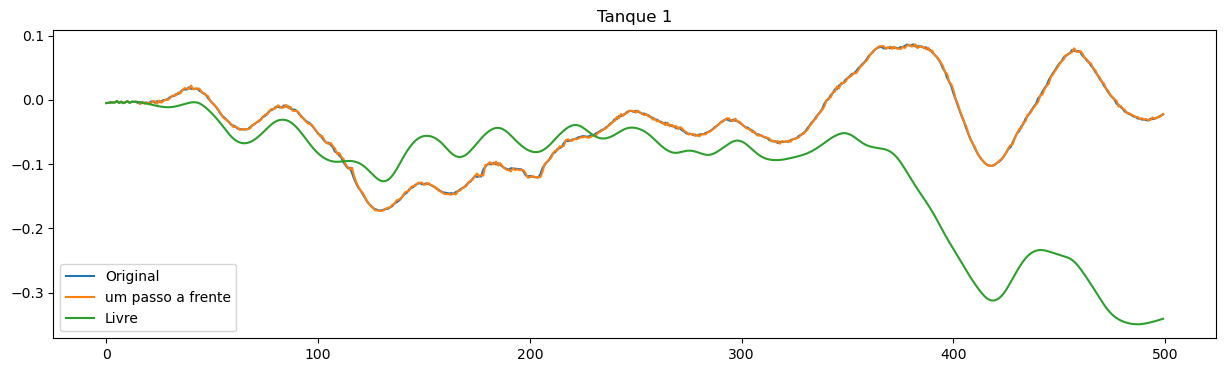

In [3]:
plt.figure(figsize=(15,4))
plt.title("Tanque " + str(output+1))
plt.plot(y[output].T, label='Original')
plt.plot(yhat, label='um passo a frente')
plt.plot(slivre, label='Livre')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


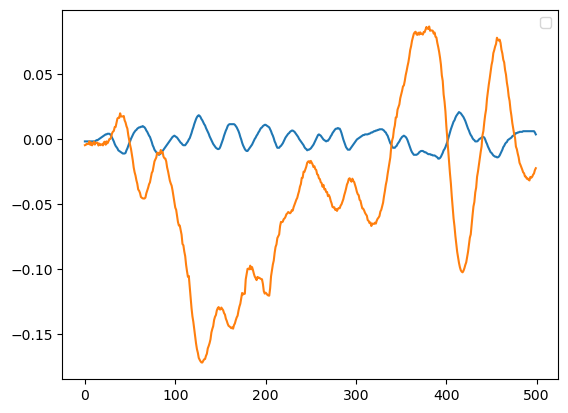

In [38]:
plt.plot(u.T)
plt.plot(y.T)
plt.legend()
plt.show()